# Assignment 3 : Sequence labelling with RNNs
In this assignement we will ask you to perform POS tagging.

You are asked to follow these steps:
*   Download the corpora and split it in training and test sets, structuring a dataframe.
*   Embed the words using GloVe embeddings
*   Create a baseline model, using a simple neural architecture
*   Experiment doing small modifications to the model
*   Evaluate your best model
*   Analyze the errors of your model

**Corpora**:
Ignore the numeric value in the third column, use only the words/symbols and its label.
https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip 

**Splits**: documents 1-100 are the train set, 101-150 validation set, 151-199 test set.

**Baseline**: two layers architecture: a Bidirectional LSTM and a Dense/Fully-Connected layer on top.

**Modifications**: experiment using a GRU instead of the LSTM, adding an additional LSTM layer, and using a CRF in addition to the LSTM. Each of this change must be done by itself (don't mix these modifications).

**Training and Experiments**: all the experiments must involve only the training and validation sets.

**Evaluation**: in the end, only the best model of your choice must be evaluated on the test set. The main metric must be F1-Macro computed between the various part of speech (without considering punctuation classes).

**Error Analysis** (optional) : analyze the errors done by your model, try to understand which may be the causes and think about how to improve it.

**Report**: You are asked to deliver a small report of about 4-5 lines in the .txt file that sums up your findings.

### Init
- Fix random seeds for reproducibile results.
This cannot be done entirely due to keras GPU intrinsically non-deterministic operations (https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development)

- Enable Weights&biases, a platform for experiment logging. (keep it disabled if no login is available)


In [1]:
#@title Init
import os
import random
import math
import numpy as np
import tensorflow as tf

# fix random seeds
seed_value = 42 #@param {type:"integer"}

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Weigths and Biases API int
ENABLE_WANDB = False        #@param {type:"boolean"}
if ENABLE_WANDB:
    !pip install wandb
    !wandb login wandb_api_token
    import wandb

### Dataset
The dataset is split in Train, Validation and Test as requested.  
Documents are splitted in sentences for Train and Validation, to reduce the usage of padding and allow for finer batch control.

In [2]:
#@title create dataset

import pandas as pd

# download and extract
!wget https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip
!unzip dep* > /dev/null

# dataset split by index
def split(i):
    if i <= 100:
        return 'train'
    elif i <= 150:
        return 'val'
    else:
        return 'test'

# build the pandas dataframe
def build_df():
    folder = os.path.join(os.getcwd(), "dependency_treebank")
    files = os.listdir(folder)
    files.sort()
    rows = {'train': [], 'val': [], 'test': []}
    for i, filename in enumerate(files):
        file_path = os.path.join(folder, filename)
        if os.path.isfile(file_path):
            words, pos = [], []
            with open(file_path, mode='r', encoding='utf-8') as text_file:
                for line in text_file:
                    tokens = line.split('\t')[:2]
                    if len(tokens) == 2:
                        words.append(tokens[0]); pos.append(tokens[1])
                    # end of sentence
                    if tokens[0] == '.' and split(i) != 'test':
                        rows[split(i)].append({"word": words, "pos": pos})
                        words, pos = [], []
                if split(i) == 'test':
                    rows[split(i)].append({"word": words, "pos": pos})
                    words, pos = [], []
                    
    df_train = pd.DataFrame(rows['train'])
    df_val = pd.DataFrame(rows['val'])
    df_test = pd.DataFrame(rows['test'])
    return df_train, df_val, df_test 

df_train, df_val, df_test = build_df()
df_train

--2020-11-30 18:40:53--  https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 457429 (447K) [application/zip]
Saving to: ‘dependency_treebank.zip.1’

dependency_treebank 100%[===================>] 446.71K  --.-KB/s    in 0.02s   

2020-11-30 18:40:53 (27.3 MB/s) - ‘dependency_treebank.zip.1’ saved [457429/457429]

caution: filename not matched:  dependency_treebank.zip
caution: filename not matched:  dependency_treebank.zip.1


,word,pos
0,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ..."
2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."
3,"[A, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS..."
4,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V..."
...,...,...
1953,"[In, separate, floor, action, ,, the, House, w...","[IN, JJ, NN, NN, ,, DT, NNP, VBD, NN, NNS, CC,..."
1954,"[The, funding, is, attached, to, an, estimated...","[DT, NN, VBZ, VBN, TO, DT, VBN, $, CD, CD, NN,..."
1955,"[The, leadership, hopes, to, move, the, compro...","[DT, NN, VBZ, TO, VB, DT, NN, NN, RB, TO, DT, ..."
1956,"[The, most, recent, example, was, a, nearly, $...","[DT, RBS, JJ, NN, VBD, DT, RB, $, CD, CD, JJ, ..."


### Vocabularies and Embedding
- Here we downoad the selected size GloVe pre-trained word embeddings.  
- This is then used to incrementally build Train, Validation and Test vocabularies, respectively v2, v3 and v4.  
The code proceeds as follows:
0. build POS tag vocabulary and inverse one.
- repeat 1-6 for each one of train, val, test different vocabularies 
1. build separate vocabularies
2. merge with previous vocabulary with consistent indices
3. parse txt data to categorical (for embedding layer)
4. build inverse vocabulary
5. build co_occurrence_matrix for handling OOV terms and embed them
6. concatenate pad and unk vectors to embedding


In [3]:
import gensim
import gensim.downloader as gloader
from collections import OrderedDict, Counter
from itertools import chain
from functools import reduce

import scipy    # defines several types of efficient sparse matrices
from tqdm import tqdm

def co_occurrence_count(df, idx_to_word, window_size=1, sparse=True):
    """Builds word-word co-occurrence matrix based on word counts."""

    vocab_count = len(idx_to_word)
    if sparse:
        co_occurrence_matrix = scipy.sparse.lil_matrix((len(idx_to_word), len(idx_to_word)), dtype=int)
    else:
        co_occurrence_matrix = np.zeros(shape=(vocab_count, vocab_count), dtype='float32')
    
    for doc in tqdm(df["word"]):
        for i, token in enumerate(doc):
            
            window = doc[max(i-window_size, 0) : i+window_size+1]        
            for dd in window:
                co_occurrence_matrix[token, dd] += 1
                
    co_occurrence_matrix[np.diag_indices(vocab_count)] = 0 # zeroes diag
    
    if sparse:
        return scipy.sparse.csr_matrix(co_occurrence_matrix)
    return co_occurrence_matrix

# build indices and reverse indices dictionary
def build_unique_voc(words, special_tokens=[]):
    """Builds POS token and support vocabularies."""

    words = words.map(lambda s: Counter([w.lower().strip() for w in s]))
    count = reduce(lambda a,b: a+b, words)
    w2i = OrderedDict()
    i2w = OrderedDict()
    for i,w in enumerate(chain(special_tokens, count)):
        w2i[w] = i
        i2w[i] = w
    return w2i, i2w

def text_to_categorical(df, w2i, p2i):
    """Converts DataFrame words to categorical for use in the RNNs"""
    df['word'] = df['word'].map(lambda s: [w2i.get(w.lower().strip(), w2i[UNK]) for w in s])
    df['pos'] = df['pos'].map(lambda s: [p2i.get(w.lower().strip()) for w in s])

def load_embedding_model(embedding_dimension=50):
    """Loads GloVe with specified embedding dimension."""
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Error downloading GloVe")
        raise e
    return emb_model

def merge_voc(old_voc, add_voc):
    """Merges vocabularies keeping consistent indices."""
    voc = old_voc.copy()
    added_counter = 0
    oov_terms = []
    for i, word in enumerate(add_voc.keys()):
        if word not in old_voc.keys():
            oov_terms.append(word)
            voc[word] = added_counter + len(old_voc)
            added_counter += 1
    return voc, oov_terms

def embedd_OOV_terms(embedding_model, oov_terms, co_occurrence_matrix, w2i, i2w, rnd_OOV = False):
    """Embedd OOV words by weighted average of co-occurring neighbors."""
    for i, word in enumerate(oov_terms):
        if rnd_OOV:
            oov_vec = np.random.rand(embedding_dimension)
        else:
            oov_vec = np.zeros(embedding_dimension)
            for count_row in co_occurrence_matrix[w2i[word]]:
                weights_acc = 0
                for count, index in zip(count_row.data, count_row.indices):
                    if i2w[index] not in oov_terms:
                        weights_acc += count
                        oov_vec += count*embedding_model[i2w[index]]

            oov_vec/=weights_acc
        embedding_model.add(word, oov_vec)

    return embedding_model


# download pretrained GloVe embedding
embedding_dimension = 100 #@param [50, 100, 300] {type:"raw"}
print("Downloading Glove embedding with dimension:", embedding_dimension)
print("Be ",int(np.sqrt((embedding_dimension//50 - 1)))*"very ","patient :)",sep='')
embedding_model = load_embedding_model(embedding_dimension)

# allows "PAD" to have index zero, crucial for consistency
PAD, UNK, = '<pad>', '<unk>'
pad_unk_vec = np.zeros((2, embedding_dimension)) # pad
pad_unk_vec[1] = np.random.rand(embedding_dimension) # unk

# pos tag vocabulary
p2i, i2p = build_unique_voc(df_train['pos'], [PAD, UNK])
v1 = {e:i for i,e in enumerate(chain([PAD, UNK], embedding_model.vocab.keys()))}

# v2 (glove + train)
print("Building train vocabulary...")
w2i_train, _ = build_unique_voc(df_train['word'])
v2, oov1 = merge_voc(v1, w2i_train)
print(f"Found {len(oov1)} oov words: {len(oov1)/len(w2i_train):.2%}")
text_to_categorical(df_train, v2, p2i)
inv2 = {v:k for k,v in v2.items()}
co_occ1 = co_occurrence_count(df_train, inv2, sparse=True)
embeding_model = embedd_OOV_terms(embedding_model, oov1, co_occ1, v2, inv2)
embedding_matrix_v2 = np.concatenate((pad_unk_vec, embedding_model.vectors.copy()))

# v3 (glove + train + val)
print("Building validation vocabulary...")
w2i_val, _ = build_unique_voc(df_val['word'])
v3, oov2 = merge_voc(v2, w2i_val)
print(f"Found {len(oov2)} oov words: {len(oov2)/len(w2i_val):.2%}")
text_to_categorical(df_val, v3, p2i)
inv3 = {v:k for k,v in v3.items()}
co_occ2 = co_occurrence_count(df_val, inv3, sparse=True)
embeding_model = embedd_OOV_terms(embedding_model, oov2, co_occ2, v3, inv3)
embedding_matrix_v3 = np.concatenate((pad_unk_vec, embedding_model.vectors.copy()))

# v4 (glove + train + val + test)
print("Building test vocabulary...")
w2i_test, _ = build_unique_voc(df_test['word'])
v4, oov3 = merge_voc(v3, w2i_test)
print(f"Found {len(oov3)} oov words: {len(oov3)/len(w2i_test):.2%}")
text_to_categorical(df_test, v4, p2i)
inv4 = {v:k for k,v in v4.items()}
co_occ3 = co_occurrence_count(df_test, inv4, sparse=True)
embeding_model = embedd_OOV_terms(embedding_model, oov3, co_occ3, v4, inv4)
embedding_matrix_v4 = np.concatenate((pad_unk_vec, embedding_model.vectors.copy()))


Be very patient :)
Building train vocabulary...
Found 362 oov words: 4.84%


100%|██████████| 1958/1958 [00:00<00:00, 2181.27it/s]


Building validation vocabulary...
Found 189 oov words: 3.54%


100%|██████████| 1242/1242 [00:00<00:00, 2248.58it/s]


Building test vocabulary...
Found 125 oov words: 3.70%


100%|██████████| 48/48 [00:00<00:00, 168.22it/s]


### Models

##### Base RNN class:
We create a base RNN Model class.  
It implements `input_layer` and `embedding_layer` attributes and `loss_function`, `update_metrics` and `copy_weights` methods.  

##### Extensions:
Each of BiLSTM, BiGRU, BiLSTM_BiLSTM extend RNN by implementing additional constructor attributes:
1. BiLSTM adds one `Bidirectional LSTM` layer and fully connected softmax head.
2. BiGRU adds one  `Bidirectional GRU` layer and same fully connected softmax head.
3. BiLSTM_BiLSTM adds two subsequent `Bidirectional LSTM` layers and fc softmax head.  
The loss for these models is `sparse_categorical_crossentropy` masked to exclude paddings and punctuation: `  (',',  '.',  ':')`.

##### Custom CRF layer:
BiLSTM_CRF extends RNN and overrides `loss_function` and  `update_metrics` with code from `tensorflow_addons.text`
1. `loss_function` uses `- crf_log_likelihood` as the loss, padding and punctuation asre excluded as well.
2. a custom `CRF` layer is implemented and added in the constructor.

##### Embedding layer
It is used to store the vocabulary embeddings. This speeds up the computations as only the categoraical indices has to be copied to GPU each time, instead of `embedding_dim` long vectors.

##### About f1 macro metric: 
the proposed approach is an underestimate of f1 macro: the approximation is needed because the score is computed on batches and every batch could lack some classes, in that case a zero is used to avoid zero-division error.  
bigger batches lead to a better approximation.

In [4]:
#@title build models

from sklearn.metrics import f1_score
from tensorflow.keras.models import Model
from tensorflow_addons.text import crf_log_likelihood, crf_decode
from tensorflow.keras.layers import (Input, LayerNormalization, LSTM, Dense, 
                                     Bidirectional, GRU, Embedding)

# base class model
class RNN(tf.keras.Model):
    def __init__(self, tag_vocab_size, 
                 sequence_len, embedding_matrix, batch_size):
        super(RNN, self).__init__()
        word_voc = embedding_matrix.shape[0]
        embedding_dim = embedding_matrix.shape[1]
        # input and embedding layers are shsred among all the models
        self.input_layer = Input(batch_input_shape=(batch_size, sequence_len))
        self.embedding_layer = Embedding(word_voc, embedding_dim,
                            weights=[embedding_matrix], trainable=False,
                            mask_zero=True)
    def build(self):
        return Model(inputs=[self.input_layer], outputs=self(self.input_layer))

    def copy_weights(self, model):
        assert type(model).__name__ == type(self).__name__
        for layer, model_layer in zip(self.layers[1:], model.layers[1:]):
            layer.set_weights(model_layer.get_weights())

    def loss_function(self, y, predictions):
        mask = tf.math.logical_not(tf.math.equal(y, p2i[PAD])) # pad mask
        sce = tf.keras.losses.sparse_categorical_crossentropy(
                y, predictions, from_logits=False)
        mask = tf.cast(mask, dtype=sce.dtype)
        sce *= mask
        return tf.reduce_sum(sce)/tf.reduce_sum(mask)

    def update_metrics(self, y, predictions, loss_obj, acc_obj, f1_obj):
        # loss
        current_loss = self.loss_function(y, predictions)
        loss_obj.update_state(current_loss)

        p1 = tf.math.logical_or(tf.math.equal(y, p2i[PAD]),tf.math.equal(y, p2i['.']))
        p2 = tf.math.logical_or(tf.math.equal(y, p2i[',']),tf.math.equal(y, p2i[':']))
        punctuation = tf.math.logical_or(p1, p2)
        punctuation = tf.math.equal(y, p2i[PAD])
        sample_weights = tf.math.logical_not(punctuation)
        pred_np = np.argmax(predictions, axis=2)
        # accuracy
        acc_obj.update_state(y, pred_np, sample_weight=sample_weights)
        # f1 macro
        y_np = y.numpy().astype(np.int32)
        f1 = f1_score(y_np.flatten(), pred_np.flatten(), 
                        sample_weight=tf.reshape(sample_weights,[-1]),
                        average='macro', zero_division=0, 
                        labels=[*p2i.values()])
        f1_obj.update_state(f1) 

# bidirectional lstm + dense ###################################################
class BiLSTM(RNN):
    def __init__(self, tag_vocab_size, 
                 sequence_len, embedding_matrix, batch_size, lstm_dim):
        super(BiLSTM, self).__init__(tag_vocab_size, 
                                     sequence_len, embedding_matrix, batch_size)
        self.lstm = Bidirectional(LSTM(
            lstm_dim, return_state=True, return_sequences=True))
        self.fc = Dense(tag_vocab_size, activation='softmax')
        
    def __call__(self, x):
        embedded = self.embedding_layer(x)
        lstm_o, lstmf_h, lstmf_c, lstmb_h, lstmb_c = self.lstm(embedded)
        output = self.fc(lstm_o)
        return output

# bidirectional lstm + dense ###################################################
class BiGRU(RNN):
    def __init__(self, tag_vocab_size, 
                 sequence_len, embedding_matrix, batch_size, gru_dim):
        super(BiGRU, self).__init__(tag_vocab_size, 
                                    sequence_len, embedding_matrix, batch_size)
        self.gru = Bidirectional(GRU(
            gru_dim, return_state=True, return_sequences=True))
        self.fc = Dense(tag_vocab_size, activation='softmax')
        
    def __call__(self, x):
        embedded = self.embedding_layer(x)
        gru_o, gru_sf, gru_sb = self.gru(embedded)
        output = self.fc(gru_o)
        return output

# bidirectional lstm + bidirectional lstm ######################################
class BiLSTM_BiLSTM(RNN): 
    def __init__(self, tag_vocab_size, 
                 sequence_len, embedding_matrix, batch_size, lstm_dim):
        super(BiLSTM_BiLSTM, self).__init__(tag_vocab_size, 
                                            sequence_len, embedding_matrix, batch_size)
        self.lstm1 = Bidirectional(LSTM(
            lstm_dim, return_state=True, return_sequences=True))
        self.lstm2 = Bidirectional(LSTM(
            lstm_dim, return_state=True, return_sequences=True))
        self.fc = Dense(tag_vocab_size, activation='softmax')
        
    def __call__(self, x):
        embedded = self.embedding_layer(x)
        lstm_o, lstmf_h, lstmf_c, lstmb_h, lstmb_c = self.lstm1(embedded)
        lstm_o, lstmf_h, lstmf_c, lstmb_h, lstmb_c = self.lstm2(lstm_o)
        output = self.fc(lstm_o)
        return output

# bidirectional lstm + crf #####################################################
class BiLSTM_CRF(RNN):
    def __init__(self, tag_vocab_size, 
                 sequence_len, embedding_matrix, batch_size, lstm_dim):
        super(BiLSTM_CRF, self).__init__(tag_vocab_size, 
                                         sequence_len, embedding_matrix, batch_size)
        self.lstm = Bidirectional(LSTM(
            lstm_dim, return_state=True, return_sequences=True))
        self.fc = Dense(tag_vocab_size, activation=None)
        self.crf = CRF(tag_vocab_size)

    def __call__(self, x):
        embedded = self.embedding_layer(x)
        lstm_o, lstmf_h, lstmf_c, lstmb_h, lstmb_c = self.lstm(embedded)
        dense_out = self.fc(lstm_o)
        output = self.crf(dense_out)
        return output

    def loss_function(self, y, pred):
        viterbi_sequence, potentials, sequence_length, chain_kernel = pred
        # the CRF loss:
        crf_loss = -crf_log_likelihood(potentials, y, sequence_length, chain_kernel)[0]
        return tf.reduce_mean(crf_loss)

    def update_metrics(self, y, pred, loss_obj, acc_obj, f1_obj):
        viterbi_sequence, _, _, _ = pred
        # loss
        current_loss = self.loss_function(y, predictions)
        loss_obj.update_state(current_loss)

        p1 = tf.math.logical_or(tf.math.equal(y, p2i[PAD]),tf.math.equal(y, p2i['.']))
        p2 = tf.math.logical_or(tf.math.equal(y, p2i[',']),tf.math.equal(y, p2i[':']))
        punctuation = tf.math.logical_or(p1, p2)
        punctuation = tf.math.equal(y, p2i[PAD])
        sample_weights = tf.math.logical_not(punctuation)
        # accuracy
        acc_obj.update_state(y, viterbi_sequence, sample_weight=sample_weights)
        # f1 macro
        # this approach is an underestimate of f1 macro:
        # the approximation is needed because the score is computed on batches
        # every batch could lack some classes, in that case a zero is used to avoid zerodivision error
        # bigger batches lead to a better approximation.

        y_np = y.numpy().astype(np.int32)
        f1 = f1_score(y_np.flatten(), viterbi_sequence.numpy().flatten(), 
                        sample_weight=tf.reshape(sample_weights,[-1]),
                        average='macro', zero_division=0, 
                        labels=[*p2i.values()])
        f1_obj.update_state(f1) 

class CRF(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(CRF, self).__init__(**kwargs)
        chain_initializer = tf.keras.initializers.get("orthogonal")
        # weights of the layer
        self.transitions = self.add_weight(shape=[units, units], 
                                           initializer=chain_initializer)

    def call(self, inputs, mask=None, training=None):
        sequence_lengths = tf.reduce_sum(tf.cast(mask, 'float32'), axis=-1)
        # method to compute crf 
        viterbi_sequence, _ = crf_decode(
            inputs, self.transitions, sequence_lengths)
        viterbi_sequence = tf.cast(viterbi_sequence, 'float32')
        return viterbi_sequence, inputs, sequence_lengths, self.transitions

### Train eval loop
- Dataset is handled with `DataIterator` class for batch creation, padding and shuffling.
- `train_step_graph_fn` and `val_step_graph_fn` are compiled with `@tf.function` decorator.
- `batch_size`, `max_epochs`, `learning_rate`, `latent_dim` and `RNNModel` hyperparameters are exposed in the Notebook form.
- The training loop implements early stopping with patience of 3 (validation computed every 5 epochs), and `best_model` backup.  
### Best Model and parameters
Our best model is BiLSTM_CRF with `batch_size, latent_dim = 64`.  
A `learning_rate = 5e-3` allows for reasonably fast training and consistent results.  

In [5]:
# helper class to iterate the data
class DataIterator:
    def __init__(self, df, sequence_len, batch_size):
        self.X = df['word'].to_numpy()
        self.Y = df['pos'].to_numpy()
        assert self.X.shape[0] == self.Y.shape[0]
        self.num_sentence = self.X.shape[0]
        self.batch_size = batch_size
        # pad sentences
        self.data_list = []
        for i in range(self.num_sentence):
            m = np.zeros((sequence_len))
            n = np.zeros(sequence_len) + p2i[PAD]
            l = min(len(self.X[i]), sequence_len)
            m[:l] = self.X[i][:l]
            n[:l] = self.Y[i][:l]
            self.data_list.append((m, n))
        self.shuffle()

    def shuffle(self):
        self.current = 0
        random.shuffle(self.data_list)
        # batch the data
        num_batches = math.ceil(self.num_sentence/self.batch_size)
        self.batches_x = []
        self.batches_y = []
        for i in range(num_batches):
            batchx = []
            batchy = []
            for j in range(self.batch_size):
                if i*batch_size+j >= self.num_sentence:
                    break
                batchx.append(self.data_list[i*self.batch_size+j][0])
                batchy.append(self.data_list[i*self.batch_size+j][1])
            self.batches_x.append(np.array(batchx))
            self.batches_y.append(np.array(batchy))

    def __iter__(self):
        return self

    def __next__(self):
        if self.current >= len(self.batches_x):
            raise StopIteration
        x = self.batches_x[self.current]
        y = self.batches_y[self.current]
        x = tf.cast(x, tf.float32)
        y = tf.cast(y, tf.float32)
        self.current += 1
        return x,y

@tf.function
def train_step_graph_fn(optimizer, model, x, y):
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = model.loss_function(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return predictions

@tf.function
def val_step_graph_fn(model, x):
    predictions = model(x)
    return predictions   

# hyperparameters
sequence_len = 128
batch_size =   64#@param {type:"integer"}
max_epochs = 100 #@param {type:"integer"}
learning_rate = 5e-3 #@param {type:"number"}
latent_dim =   64#@param {type:"integer"}
RNNModel = BiLSTM_CRF #@param ['BiLSTM', 'BiGRU', 'BiLSTM_BiLSTM', 'BiLSTM_CRF'] {type:"raw"}

if ENABLE_WANDB:
    wandb.config.batch_size = batch_size
    wandb.config.max_epochs = max_epochs
    wandb.config.latent_dim = latent_dim
    wandb.config.learning_rate = learning_rate 
    wandb.config.emdedding_dim = embedding_dimension
    wandb.config.model = RNNModel.__name__
    wandb_experiment_name = f"{RNNModel.__name__}_e{embedding_dimension}_b{batch_size}_{latent_dim}_lr{learning_rate:.0e}"
    wandb.init(project="NLP03", name=wandb_experiment_name)

pos_vocab_size = len(p2i.keys())
# train model
model = RNNModel(pos_vocab_size, sequence_len, embedding_matrix_v2, 
                 batch_size, latent_dim)
model.build().summary()
# val model
val_model = RNNModel(pos_vocab_size, sequence_len, embedding_matrix_v3, 
                 batch_size, latent_dim)
val_model.build()
# best model
best_model = RNNModel(pos_vocab_size, sequence_len, embedding_matrix_v3, 
                 batch_size, latent_dim)
best_model.build()

# metrics
train_loss_obj = tf.keras.metrics.Mean(name='train_loss')
train_f1_obj = tf.keras.metrics.Mean(name='train_f1')
train_acc_obj = tf.keras.metrics.Accuracy(name='train_accuracy')
val_loss_obj = tf.keras.metrics.Mean(name='val_loss')
val_f1_obj = tf.keras.metrics.Mean(name='val_f1')
val_acc_obj = tf.keras.metrics.Accuracy(name='val_accuracy')

# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_data = DataIterator(df_train, sequence_len, batch_size)
val_data = DataIterator(df_val, sequence_len, batch_size)

# train loop
max_val_loss = math.inf
not_improving = 0
max_iter_not_improv = 3

errors = []
for epoch in range(max_epochs):
    train_loss_obj.reset_states()
    train_f1_obj.reset_states()
    train_acc_obj.reset_states()

    train_data.shuffle()
    errors = errors[:-10]
    for x,y in train_data:
        predictions = train_step_graph_fn(optimizer, model, x, y)
        #errors.append((x[np.argmax(predictions, axis = -1) != y], y, predictions))
        model.update_metrics(y, predictions, train_loss_obj, train_acc_obj, train_f1_obj)

    print("{}.  \t[TRAINING]\t  loss: {}  \t accuracy: {} \t f1-macro: {}".format(epoch, 
                                                      train_loss_obj.result(),
                                                      train_acc_obj.result(),
                                                      train_f1_obj.result()))
    if ENABLE_WANDB:
        wandb.log({
            'train_loss': train_loss_obj.result(),
            'train_accuracy': train_acc_obj.result(),
            'train_f1': train_f1_obj.result()
        }, step=epoch)

    # validation

    if epoch%5 == 4:
        val_loss_obj.reset_states()
        val_acc_obj.reset_states()
        val_f1_obj.reset_states()

        val_model.copy_weights(model)
        val_data.shuffle()
        for x,y in val_data:
            predictions = val_step_graph_fn(val_model, x)
            val_model.update_metrics(y, predictions, val_loss_obj, val_acc_obj, val_f1_obj)

        print("     \t[VALIDATION]\t   loss: {}  \t  accuracy: {} \t  f1-macro: {}".format(
                                                      val_loss_obj.result(),
                                                      val_acc_obj.result(),
                                                      val_f1_obj.result()))
        if ENABLE_WANDB:
            wandb.log({
                'val_loss': val_loss_obj.result(),
                'val_accuracy': val_acc_obj.result(),
                'val_f1': val_f1_obj.result()
            }, step=epoch)

        # early stopping
        if val_loss_obj.result() < max_val_loss:
            best_model.copy_weights(val_model)
            max_val_loss = val_loss_obj.result()
            not_improving = 0
        else:
            not_improving += 1
            print("VALIDATION LOSS NOT IMPROVING, STRIKE:", not_improving,"!!")
            if not_improving >= max_iter_not_improv:
                print("Validation loss not improving for", max_iter_not_improv,
                      "successive computations.")
                print("YOU ARE OUT !!!")
                break

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 128)]               0         
_________________________________________________________________
embedding (Embedding)        (64, 128, 100)            40036400  
_________________________________________________________________
bidirectional (Bidirectional [(64, 128, 128), (64, 64) 84480     
_________________________________________________________________
dense (Dense)                (64, 128, 47)             6063      
_________________________________________________________________
crf (CRF)                    ((64, 128), (64, 128, 47) 2209      
Total params: 40,129,152
Trainable params: 92,752
Non-trainable params: 40,036,400
_________________________________________________________________
0.  	[TRAINING]	  loss: 52.201847076416016  	 accuracy: 0.46862125396728516 	 f1-macro: 0.1643742471933

### Evaluation on test set
The best model BiLSTM_CRF is selected by comparing f1-macro scores on the validation set.   
It is then used to perform inference on the whole test set. This is made of complete documents.  
The confusion matrix is build and shown, omitting the padding tag as it does not contribute to f1 score.

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, 1500)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (64, 1500, 100)           40067800  
_________________________________________________________________
bidirectional_3 (Bidirection [(64, 1500, 128), (64, 64 84480     
_________________________________________________________________
dense_3 (Dense)              (64, 1500, 47)            6063      
_________________________________________________________________
crf_3 (CRF)                  ((64, 1500), (64, 1500, 4 2209      
Total params: 40,160,552
Trainable params: 92,752
Non-trainable params: 40,067,800
_________________________________________________________________

TEST loss: 88.17252349853516  	 accuracy: 0.9161500930786133 	 f1-macro: 0.7339588403701782



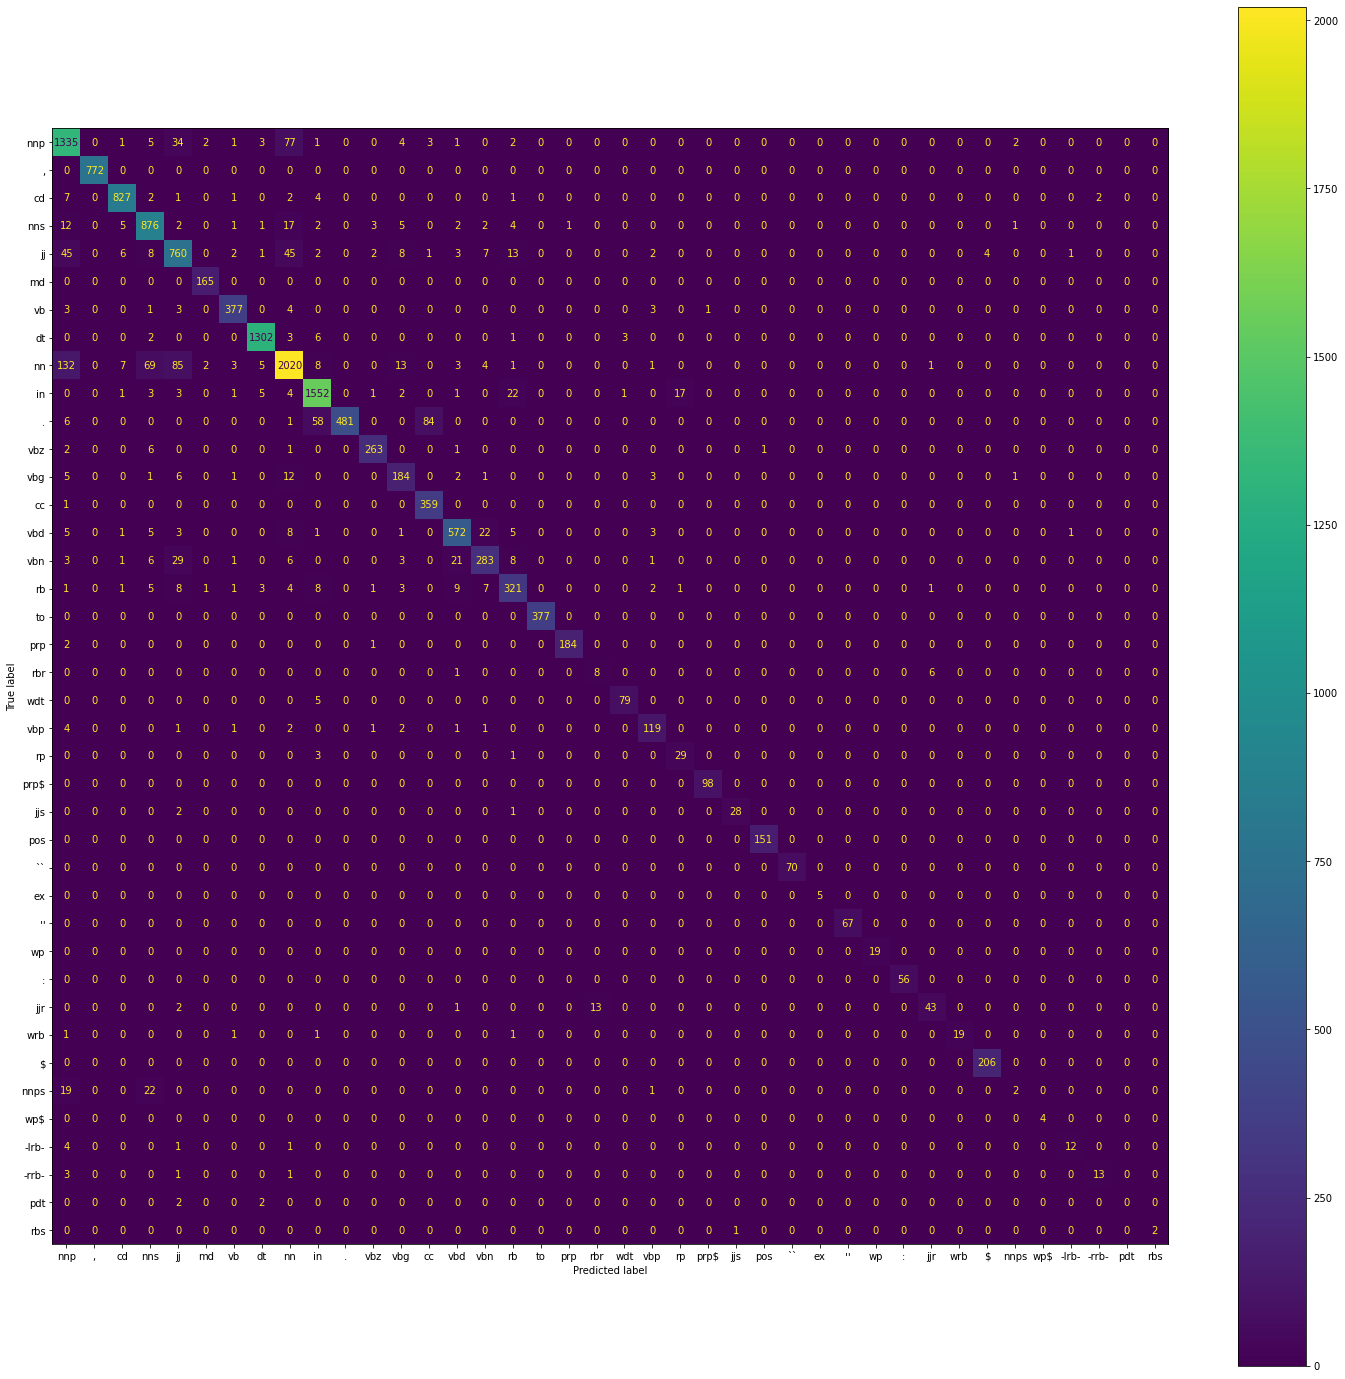

In [6]:
#@title perform test inference

test_seq_len = 1500 # max document length
test_model = RNNModel(pos_vocab_size, test_seq_len, embedding_matrix_v4, 
                      batch_size, latent_dim)
test_model.build().summary()
test_model.copy_weights(best_model)

# run on the test set
test_loss_obj = tf.keras.metrics.Mean(name='test_loss')
test_f1_obj = tf.keras.metrics.Mean(name='test_f1')
test_acc_obj = tf.keras.metrics.Accuracy(name='test_accuracy')

test_data = DataIterator(df_test, test_seq_len, batch_size)

y_acc, pred_acc = [], []
for x, y in test_data:
    predictions = val_step_graph_fn(test_model, x)
    test_model.update_metrics(y, predictions, test_loss_obj, test_acc_obj, test_f1_obj)
    y_acc += list(y.numpy().flatten())
    if type(predictions) is tuple: # CRF case
        pred_acc += list(predictions[0].numpy().flatten())
    else:                         # other models
        pred_acc += list(np.argmax(predictions, axis=2).flatten())
test_log = "\nTEST loss: {}  \t accuracy: {} \t f1-macro: {}\n".format(
                                                test_loss_obj.result(),
                                                test_acc_obj.result(),
                                                test_f1_obj.result())
print(test_log)
# Plot confusion matrix on all test set
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_acc, pred_acc)[1:,1:]
cm = cm.astype('int')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[i2p[y] for y in list(set(y_acc))][1:]) # 
fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
disp.plot(include_values=True, ax=ax,values_format='.10g', cmap='viridis');

if ENABLE_WANDB:
    wandb.log({"plot": fig})

### Error Analysis
We plot POS-tags confusion matrices for every model to analyse errors on the test set. After this step no additional model modification is done.  
   
#### BiLSTM:  
Most of the error mass is distributed simmetrically around the noun "nn" entry: this gets confused with and by: "nnp", "jj", "nns".  
Lowercasing could be the cause of confusion for proper nouns "nnp".  
"jj"-"nns" and "nns"-"nnp" pairs are confounded symmetrically, too.  
Adjectives gets confused with past particile verbs too.  
  
Another relevant error relies in confusing "." with conjunction "cc", just in this skewed direction. This is peculiar as both classes have similar counts of entries.  
Test f1-macro of 0.692

#### BiGRU:  
This model greatly fails to classify "." correctly, confusing it with "in" and "-rrb-" tags.  
The same "nn", "nnp", "jj", "nns" is seen.  
Test f1-macro of  0.709

#### BiLSTM_BiLSTM:  
The conjunction "cc" to "." error is prominent, while other errors remain similar.
Test f1-macro of 0.686


#### BiLSTM_CRF:
CRF misunderstands "." for "cc" and "in" and does slightly less errors for "nn", "nnp", "jj", "nns".  
Test f1-macro of 0.716


### Inference on general text
Inference can be done on any 1500 or less character sentence.  
Unknown tokens are handled correctly.  
An ambiguous sentence (banks) is left for testing, but generally sense disambiguation is not achieved.
Anyway, it performs relatively well.

In [7]:
#@title perform inference

import nltk; nltk.download('punkt')

def infer(model, w2i, i2p, string):
    sequence = nltk.word_tokenize(string.lower())
    cat_seq = [w2i.get(s, w2i[UNK]) for s in sequence]
    x = np.expand_dims(cat_seq, axis=0)
    x = tf.cast(x, dtype=tf.float32)
    predictions = val_step_graph_fn(model, x)
    if type(predictions) is tuple: # CRF case
        sampled_token_index = predictions[0].numpy()[0]
    else:                         # other models
        sampled_token_index = np.argmax(predictions[0], axis=1)
    pos_list = [i2p[t] for t in sampled_token_index]
    out = [(sequence[i], pos_list[i]) for i in range(len(sequence))]
    return out

# infer any string
text = """During the financial crisis, banks received $1.2 trillion in loans from the Government. (noun) When a plane turns, it banks to give the lifting force of the wings a horizontal component. (verb) """  #@param {type:"string"}
pos = infer(test_model, v4, i2p, text)

print("\nPOS TAGS:\n", pos)
if ENABLE_WANDB:
    wandb.log({"Test": wandb.Html(
        "<pre>"+test_log+"<pre>"+
        "<pre>"+str(pos)+"</pre>" , inject=False)})
print()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

POS TAGS:
 [('during', 'in'), ('the', 'dt'), ('financial', 'jj'), ('crisis', 'nn'), (',', ','), ('banks', 'nns'), ('received', 'vbd'), ('$', '$'), ('1.2', 'cd'), ('trillion', 'cd'), ('in', 'in'), ('loans', 'nns'), ('from', 'in'), ('the', 'dt'), ('government', 'nn'), ('.', '.'), ('(', 'cd'), ('noun', 'nn'), (')', ':'), ('when', 'wrb'), ('a', 'dt'), ('plane', 'nn'), ('turns', 'vbz'), (',', ','), ('it', 'prp'), ('banks', 'nns'), ('to', 'to'), ('give', 'vb'), ('the', 'dt'), ('lifting', 'vbg'), ('force', 'nn'), ('of', 'in'), ('the', 'dt'), ('wings', 'nnp'), ('a', 'dt'), ('horizontal', 'jj'), ('component', 'nn'), ('.', '.'), ('(', 'cd'), ('verb', 'nn'), (')', '.')]

